In [33]:
import numpy as np
import pandas as pd

import torch

from matplotlib import pyplot as plt

from collections import deque

from pid import PIDModel
from agent import Agent, Actor, Critic

%matplotlib inline

## Loading up Actor and Critic models

In [34]:
args = {
    "NUM_EPISODES": 10,
    "LEARNING_RATE": 0.01,
    "DEVICE": "cpu",
    "exploration_stddev": 0.2,
    "LOAD_PREVIOUS": False,
    "PRINT_EVERY": 50
}

In [35]:
T_SIZE = 500
SET_POINT = 50

t = np.linspace(0, 100, num=T_SIZE)
SP = np.ones(T_SIZE)*SET_POINT

env = PIDModel(ku=1.396, tu=3.28, t=t, SP=SP)

actor = Actor()
critic = Critic()
agent = Agent(env, lr=args["LEARNING_RATE"], actor_model=actor, critic_model=critic,
              device=args["DEVICE"])

agent.load()

Emulating some episodes
---

In [36]:
state = env.reset()
done = False
total = 0

agent.start_episode()
state, init_reward, __ = env.step((0.5, 0.5, 3.5))  # Initial random state
num_step = 0
rewards = [init_reward]
while not done:
    action = agent.get_action(state)

    new_state, reward, done = env.step(action)
    agent.step(state, action, action, reward)

    total += reward
    state = new_state
    num_step += 1
    rewards.append(reward)


y_caps = np.array(env.output())

Text(0, 0.5, 'Response')

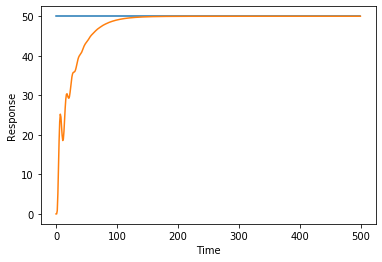

In [37]:
response = y_caps[:, 0]

plt.plot(SP, label="Set Point")
plt.plot(response, label="Response")

plt.xlabel("Time")
plt.ylabel("Response")

Text(0.5, 0, 'Time')

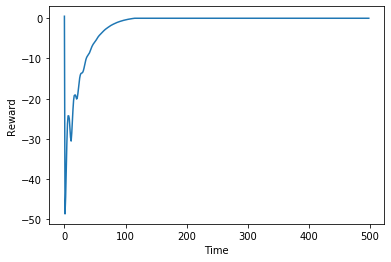

In [38]:
plt.plot(rewards)
plt.ylabel("Reward")
plt.xlabel("Time")

Text(0, 0.5, 'Error')

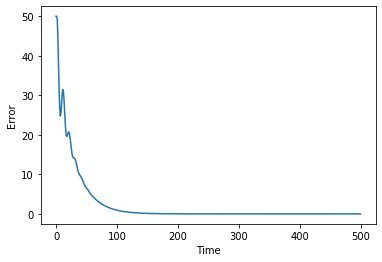

In [48]:
error = SP-response
plt.plot(error)
plt.xlabel("Time")
plt.ylabel("Error")

Text(0, 0.5, 'Derivative of error')

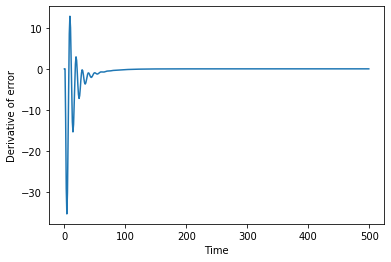

In [49]:
d_error = -y_caps[:, 1]
plt.plot(d_error)
plt.xlabel("Time")
plt.ylabel("Derivative of error")

In [65]:
# Max overshoot
error_pd = -pd.Series(error)

# Max overshoot is when |error| is maximum after touching the set point first, i.e after first crossing zero
first_cross = error_pd[((error_pd.shift() <= 0) & (error_pd >= 0))].index[0]

print("Max overshoot: ", error_pd[first_cross: ].abs().max())

Max overshoot:  2.151119787185962e-06


In [70]:
# Settling time: first occurence of when tolerance band is reached
# tolerance band is +-TOLERANCE_BAND percent of the target set point

TOLERANCE_BAND = 0.5/100 # Within 0.5% of the target is tolerable
abs_tolerance = TOLERANCE_BAND*SP[0]

settling_time = t[error_pd[(error_pd.abs() < abs_tolerance)].index[0]]
print("Settling time: ", settling_time)

Settling time:  26.85370741482966
